
Import Libraries and Check CUDA Availability
---



In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import ast
import torch.utils.data as data
from collections import defaultdict, Counter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
# Training parameters
num_classes = 36
num_sensors = 5
sequence_length = 10
batch_size = 32
train_loop_enable =1


label_to_xy func
---



In [3]:
# Khu vực chứa các nhãn
area = [
    [11, 12, 21, 22, 31, 32],
    [13, 14, 23, 24, 33, 34],
    [41, 42, 51, 52, 61, 62],
    [43, 44, 53, 54, 63, 64],
    [71, 72, 81, 82, 91, 92],
    [73, 74, 83, 84, 93, 94]
]

# Hàm chuyển đổi từ nhãn sang tọa độ (x, y) dựa trên area
# Hàm chuyển đổi từ nhãn sang tọa độ (x, y) dựa trên area
def label_to_xy(label, area):
    # Duyệt qua từng hàng và cột trong area
    for i, row in enumerate(area):
        for j, cell in enumerate(row):
            if cell == label:
                # Tọa độ x tăng từ trái sang phải, cách nhau 0.5
                x = j * 0.5 + 0.25
                # Tọa độ y tăng từ dưới lên trên, cách nhau 0.5
                y = (len(area) - i - 1) * 0.5 + 0.25
                return x, y
    # Nếu không tìm thấy nhãn, trả về None
    return None

In [4]:
def check_nan_inf(array, name="array"):
    try:
        # Chuyển đổi mảng sang kiểu float nếu có thể
        array = np.array(array, dtype=np.float64)
    except ValueError:
        print(f"{name} chứa giá trị không phải số, bỏ qua.")
        return False

    # Kiểm tra NaN và Inf
    if np.isnan(array).any():
        print(f"{name} chứa NaN.")
        return False
    if np.isinf(array).any():
        print(f"{name} chứa Inf.")
        return False

    return True



Import csv
---



In [5]:
import os
import numpy as np
import pandas as pd
import torch

# Đường dẫn thư mục chính
base_dir = "./mung_data/Data_final"

# Đảm bảo chiều dài x và y là 700
target_length = 700

padding_x = 0
offset_x_value=1500

batch_name = []

# Khởi tạo danh sách lưu dữ liệu từ các thư mục cấp 1
x_data = []
y_data = []
y_xy_data = []
time_step_data = []



# Tạo danh sách các thư mục cấp 1
level_1_dirs = sorted([d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))])

for l1_idx, l1_dir in enumerate(level_1_dirs):
    l1_path = os.path.join(base_dir, l1_dir)
    print(f"Đang xử lý thư mục cấp 1: {l1_dir}")

    # Xử lý thư mục cấp 2
    level_2_dirs = sorted([d for d in os.listdir(l1_path) if os.path.isdir(os.path.join(l1_path, d))])

    for l2_idx, l2_dir in enumerate(level_2_dirs):
        l2_path = os.path.join(l1_path, l2_dir)
        print(f"  Đang xử lý thư mục cấp 2: {l2_dir}")

        # Duyệt qua các file CSV trong thư mục cấp 2
        csv_files = sorted([f for f in os.listdir(l2_path) if f.endswith("_synced.csv")])
        i = 0
        for file in csv_files:
            file_path = os.path.join(l2_path, file)
            print(f"    Đang xử lý file CSV: {file}")

            # Đọc và xử lý file CSV
            try:
                data = pd.read_csv(file_path, header=None)
                if data.empty:
                    print(f'    File {file} trống, bỏ qua.')
                    continue

                # Danh sách lưu dòng hợp lệ
                valid_x = []
                valid_y = []
                valid_y_xy = []
                valid_time_step = []

                # Duyệt qua từng dòng của file
                for idx, row in data.iterrows():
                    try:
                        # Lấy giá trị x và y từ dòng
                        x = row[1:6].values - offset_x_value  # 5 cột
                        y = row[6]  # Nhãn
                        time_step = row[0]

                        # Chuyển đổi nhãn nếu cần
                        if isinstance(y, str) and y.startswith('id'):
                            try:
                                # Lấy phần số sau 'id'
                                num_part = int(y[2:])
                                if num_part != 0:
                                    y = int(num_part)  # Chuyển thành số thực
                                    y_xy = label_to_xy(y, area)
                                else:
                                    continue
                            except ValueError:
                                print(f"    Nhãn '{y}' không thể chuyển đổi, bỏ qua.")
                                continue

                        # Loại bỏ dòng nếu y vẫn không hợp lệ
                        if pd.isna(y):
                            print(f"    Dòng {idx} không hợp lệ, bỏ qua.")
                            continue

                        # Kiểm tra NaN và Inf
                        if not check_nan_inf(x, name=f"x (dòng {idx})") or not check_nan_inf(y, name=f"y (dòng {idx})"):
                            print(f"    Bỏ qua dòng {idx} do chứa giá trị không hợp lệ.")
                            continue
                        if not check_nan_inf(time_step, name=f"time_step (dòng {idx})"):
                            print(f"    Bỏ qua dòng {idx} do chứa giá trị không hợp lệ.")
                            continue
                        # Lưu dòng hợp lệ
                        valid_x.append(x)
                        valid_y.append(y)
                        valid_y_xy.append(y_xy)
                        valid_time_step.append(int(time_step))

                        i += 1
                        batch_name.append(f"{l1_dir}_{l2_dir}_file{i}")

                    except Exception as e:
                        print(f"    Lỗi khi xử lý dòng {idx}: {e}")

                # Chuyển danh sách thành numpy array
                valid_x = np.array(valid_x).T
                valid_y = np.array(valid_y).T
                valid_y_xy = np.array(valid_y_xy).T
                valid_time_step = np.array(valid_time_step).T

                # Thêm vào danh sách cấp 2
                x_data.append(valid_x)
                y_data.append(valid_y)
                y_xy_data.append(valid_y_xy)
                time_step_data.append(valid_time_step)

            except Exception as e:
                print(f"Lỗi khi xử lý file {file_path}: {e}")


Đang xử lý thư mục cấp 1: bt
  Đang xử lý thư mục cấp 2: cot1
    Đang xử lý file CSV: 1734510152055-1734510164061_synced.csv
    Đang xử lý file CSV: 1734510180107-1734510193637_synced.csv
    Đang xử lý file CSV: 1734510204347-1734510218468_synced.csv
    Đang xử lý file CSV: 1734510296756-1734510308351_synced.csv
    Đang xử lý file CSV: 1734510324433-1734510337669_synced.csv
    Đang xử lý file CSV: 1734510350169-1734510363282_synced.csv
    Đang xử lý file CSV: 1734510450167-1734510463020_synced.csv
    Đang xử lý file CSV: 1734510503025-1734510516546_synced.csv
    Đang xử lý file CSV: 1734510529190-1734510543907_synced.csv
    Đang xử lý file CSV: 1734510570527-1734510583482_synced.csv
  Đang xử lý thư mục cấp 2: cot2
    Đang xử lý file CSV: 1734510633205-1734510646416_synced.csv
    Đang xử lý file CSV: 1734510684124-1734510698505_synced.csv
    Đang xử lý file CSV: 1734510713815-1734510728342_synced.csv
    Đang xử lý file CSV: 1734510756020-1734510769337_synced.csv
    Đang 


noise_filter func
---



In [6]:
import numpy as np
import scipy.signal as signal

def noise_filter(x, fs=100, fc=3.5):
    """
    Lọc thông thấp để giảm nhiễu tín hiệu.

    Parameters:
        x (numpy.ndarray): Tín hiệu đầu vào, mảng 2D với mỗi hàng là một chuỗi tín hiệu.
        fs (int): Tần số lấy mẫu (Hz). Mặc định là 100 Hz.
        fc (float): Tần số cắt (Hz). Mặc định là 3.5 Hz.

    Returns:
        numpy.ndarray: Tín hiệu sau khi lọc nhiễu, có cùng kích thước với x.
    """
    # Tạo bộ lọc Butterworth
    b, a = signal.butter(N=4, Wn=fc / (fs / 2), btype='low')  # Bộ lọc Butterworth bậc 4

    # Áp dụng bộ lọc thông thấp
    x_filtered = []
    for row in x:
        # Kiểm tra nếu row là một mảng NumPy hoặc danh sách
        if isinstance(row, (np.ndarray, list)) and np.ndim(row) == 1:
            if len(row) > 0:  # Chỉ xử lý nếu hàng không rỗng
                filtered_row = signal.filtfilt(b, a, row)  # Lọc tín hiệu
                x_filtered.append(filtered_row)
            else:
                x_filtered.append(np.array([]))  # Giữ nguyên nếu rỗng
        else:
            # Xử lý khi row không phải là mảng 1D
            print(f"Cảnh báo: Bỏ qua hàng không hợp lệ ({type(row)})")
            x_filtered.append(np.array([]))
    return np.array(x_filtered, dtype=object)  # Trả về mảng object để tránh lỗi định dạng
filtered_x_data=[]
for i in range(len(x_data)):
    filtered_x_data.append(noise_filter(x_data[i]))
print("da loc x_data")
x_data=filtered_x_data

da loc x_data



Tensor convert
---



In [7]:
import numpy as np
import torch
import numpy as np
import torch

# Khởi tạo danh sách cho dữ liệu cắt
x_data_cut = []
y_data_cut = []
y_xy_data_cut = []
time_step_data_cut = [] #--------------------------------------------------------
step = sequence_length

# Cắt dữ liệu
for i in range(len(x_data)):
    num_slices = len(y_data[i]) // step  # Tính số lần cắt tối đa
    for j in range(num_slices):
        start_cut = j * step
        end_cut = start_cut + step

        # Cắt dữ liệu cho x và y
        x_cut = [x_data[i][k][start_cut:end_cut] for k in range(5)]  # 5 đặc trưng (cột)
        y_cut = y_data[i][start_cut:end_cut]

        y_xy_cut = [y_xy_data[i][k][start_cut:end_cut] for k in range(2)]  # 2 toa do (cột)
        time_step_cut = time_step_data[i][start_cut:end_cut] #--------------------------------------------------------

        # Kiểm tra dữ liệu hợp lệ
        if len(y_cut) == step and all(len(feature) == step for feature in x_cut):
            # Append data, ensuring it's stored as numpy arrays with dtype uint64
            x_data_cut.append(np.array(x_cut))  # Ensure x_cut is a numpy array
            y_data_cut.append(np.array(y_cut, dtype=np.uint64))  # Explicitly set dtype to uint64
            y_xy_data_cut.append(np.array(y_xy_cut))  # Ensure y_xy_cut is a numpy array
            time_step_data_cut.append(np.array(time_step_cut, dtype=np.uint64))  # Explicitly set dtype to uint64#--------------------------------------------------------


# Kiểm tra kích thước dữ liệu chi tiết
print("Kiểm tra kích thước các phần tử trước khi stack:")
x_shapes = [arr.shape for arr in x_data_cut]
y_shapes = [arr.shape for arr in y_data_cut]
y_xy_shapes = [arr.shape for arr in y_xy_data_cut]
time_step_shapes = [arr.shape for arr in time_step_data_cut]#--------------------------------------------------------

# Sử dụng Counter để đếm các kích thước khác nhau
from collections import Counter
print(f"Kích thước x_data_cut: {Counter(x_shapes)}")
print(f"Kích thước y_data_cut: {Counter(y_shapes)}")
print(f"Kích thước y_xy_data_cut: {Counter(y_xy_shapes)}")
print(f"Kích thước time_step_cut: {Counter(time_step_shapes)}")#--------------------------------------------------------

# Phát hiện các phần tử không đồng nhất
# if len(set(x_shapes)) > 1 or len(set(y_shapes)) > 1 or len(set(y_xy_shapes)) > 1:
if len(set(x_shapes)) > 1 or len(set(y_shapes)) > 1 or len(set(y_xy_shapes)) > 1 or len(set(time_step_shapes)) > 1:
    print("Phát hiện các phần tử không đồng nhất:")
    for idx, shape in enumerate(x_shapes):
        if shape != x_shapes[0]:
            print(f"x_data_cut[{idx}] có kích thước không đồng nhất: {shape}")
    for idx, shape in enumerate(y_shapes):
        if shape != y_shapes[0]:
            print(f"y_data_cut[{idx}] có kích thước không đồng nhất: {shape}")
    for idx, shape in enumerate(y_xy_shapes):
        if shape != y_xy_shapes[0]:
            print(f"y_xy_data_cut[{idx}] có kích thước không đồng nhất: {shape}")
    for idx, shape in enumerate(time_step_shapes):#--------------------------------------------------------
        if shape != time_step_shapes[0]:#--------------------------------------------------------
            print(f"time_step_cut[{idx}] có kích thước không đồng nhất: {shape}")#--------------------------------------------------------
    raise ValueError("Các phần tử trong x_data_cut hoặc y_data_cut hoặc y_xy_data_cut hoặc time_step_data_cut không đồng nhất!")

# Chuyển đổi x_data_cut, y_data_cut, và y_xy_data_cut thành numpy arrays
try:
    x_data_cut = np.array(x_data_cut, dtype=float)
    y_data_cut = np.array(y_data_cut, dtype=np.uint64)
    y_xy_data_cut = np.array(y_xy_data_cut, dtype=float)
    time_step_data_cut = np.array(time_step_data_cut, dtype=np.uint64)#--------------------------------------------------------
except Exception as e:
    print("Lỗi khi chuyển đổi dữ liệu sang numpy array:")
    print(e)
    raise

# Chuyển đổi sang PyTorch tensors
try:
    x_tensor = torch.tensor(x_data_cut, dtype=torch.float32)
    y_tensor = torch.tensor(y_data_cut, dtype=torch.int64)
    y_xy_tensor = torch.tensor(y_xy_data_cut, dtype=torch.float32)
    time_step_tensor = torch.tensor(time_step_data_cut, dtype=torch.int64)#--------------------------------------------------------
except Exception as e:
    print("Lỗi khi chuyển đổi numpy array sang PyTorch tensor:")
    print(e)
    raise

# Kiểm tra kết quả
print(f"Kích thước x_tensor: {x_tensor.shape}")
print(f"Kích thước y_tensor: {y_tensor.shape}")
print(f"Kích thước y_xy_tensor: {y_xy_tensor.shape}")
print(f"Kích thước time_step_tensor: {time_step_tensor.shape}")#--------------------------------------------------------


Kiểm tra kích thước các phần tử trước khi stack:
Kích thước x_data_cut: Counter({(5, 10): 27422})
Kích thước y_data_cut: Counter({(10,): 27422})
Kích thước y_xy_data_cut: Counter({(2, 10): 27422})
Kích thước time_step_cut: Counter({(10,): 27422})
Kích thước x_tensor: torch.Size([27422, 5, 10])
Kích thước y_tensor: torch.Size([27422, 10])
Kích thước y_xy_tensor: torch.Size([27422, 2, 10])
Kích thước time_step_tensor: torch.Size([27422, 10])



z_score func
---



In [8]:
# Chuẩn hóa Z-Score
def z_score(x_data_cut,d=2, epsilon = 1e-8):
    x_mean = np.mean(x_data_cut, axis=(0, d), keepdims=True)  # Tính giá trị trung bình cho từng đặc trưng
    x_std = np.std(x_data_cut, axis=(0, d), keepdims=True)    # Tính độ lệch chuẩn cho từng đặc trưng

    x_data_cut_standardized = (x_data_cut - x_mean) / (x_std + epsilon)

    # print(f"Chuẩn hóa Z-Score, kích thước x_tensor: {x_tensor.shape}")
    return x_data_cut_standardized



train set
---



In [9]:
X_train = x_tensor.to(device)  # Stack them into a tensor and move to the device
Y_train = y_xy_tensor.to(device)  # Stack the labels into a tensor and move to the device
TIMESTEP = time_step_tensor.to(device)  # Stack the labels into a tensor and move to the device #----------------------------

# Verify data shapes
print("Kích thước của x_train:", X_train.shape)
print("Kích thước của y_train:", Y_train.shape)
print("Kích thước của y_train:", TIMESTEP.shape)


Kích thước của x_train: torch.Size([27422, 5, 10])
Kích thước của y_train: torch.Size([27422, 2, 10])
Kích thước của y_train: torch.Size([27422, 10])


Splitting dataset
---




In [10]:
import torch.utils.data as data
# Split dataset
train_size = int(0.8 * len(X_train))
test_size = len(X_train) - train_size
# train_dataset, test_dataset = data.random_split(torch.utils.data.TensorDataset(X_train, Y_train), [train_size, test_size])
train_dataset, test_dataset = data.random_split(torch.utils.data.TensorDataset(X_train, Y_train, TIMESTEP), [train_size, test_size])


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(train_size, test_size)

21937 5485


In [11]:
def check_data(inputs, labels):
    if torch.isnan(inputs).any() or torch.isinf(inputs).any():
        print("Inputs contain NaN or Inf.")
    if torch.isnan(labels).any() or torch.isinf(labels).any():
        print("Labels contain NaN or Inf.")

for inputs, labels, ts in train_loader:
    check_data(inputs, labels)


Define Model
---

In [12]:
# Define model
class CNN1D(nn.Module):
    def __init__(self, input_size, num_classes):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(input_size, 128, 3, padding=1)
        self.conv2 = nn.Conv1d(128, 256, 3, padding=1)
        self.conv3 = nn.Conv1d(256, 512, 3, padding=1)
        self.conv4 = nn.Conv1d(512, 512, 3, padding=1)
        self.conv5 = nn.Conv1d(512, 1024, 3, padding=1)
        self.batch_norm1 = nn.BatchNorm1d(128)
        self.batch_norm2 = nn.BatchNorm1d(256)
        self.batch_norm3 = nn.BatchNorm1d(512)
        self.batch_norm4 = nn.BatchNorm1d(512)
        self.batch_norm5 = nn.BatchNorm1d(1024)
        self.dropout = nn.Dropout(0.3)
        self.padding = nn.ConstantPad1d((0, 1), 0)
        self.maxpool = nn.MaxPool1d(2, stride=1)

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)
        self.relu = nn.ReLU()

class CNNLSTM(nn.Module):
    def __init__(self, input_size):
        super(CNNLSTM, self).__init__()
        self.cnn = CNN1D(input_size, 2)  # num_classes thay bằng 2 (x, y)
        self.lstm = LSTMModel(1024, 1024, 2, 2, 0.3)  # Thay num_classes bằng 2
        self.fc = nn.Linear(1024, 2)  # Dự đoán 2 giá trị (x, y)
    def forward(self, x):
        x = self.cnn.batch_norm1(self.cnn.conv1(x))
        x = torch.relu(x)
        x = self.cnn.batch_norm2(self.cnn.conv2(x))
        x = torch.relu(x)
        x = self.cnn.batch_norm3(self.cnn.conv3(x))
        x = torch.relu(x)
        # x = self.cnn.batch_norm4(self.cnn.conv4(x))  # Thêm batch norm cho conv4
        # x = torch.relu(x)
        x = self.cnn.batch_norm5(self.cnn.conv5(x))
        x = torch.relu(x)

        x = self.cnn.padding(x)
        x = self.cnn.maxpool(x)
        x = self.cnn.dropout(x)

        # Chuẩn bị đầu vào cho LSTM
        x = x.transpose(1, 2).contiguous().view(x.size(0), -1, 1024)
        h0 = torch.zeros(2, x.size(0), 1024).to(x.device)
        c0 = torch.zeros(2, x.size(0), 1024).to(x.device)

        # LSTM đầu ra là toàn bộ chuỗi
        x, _ = self.lstm.lstm(x, (h0, c0))

        # Pass each time step qua lớp FC để dự đoán tọa độ (x, y)
        x = self.fc(x)  # Kích thước: [batch_size, sequence_length, 2]

        x=x.permute(0, 2, 1) # Hoán vị trục 1 và trục 2 [batch_size, num_targets, sequence_length]


        return x  # Trả về chuỗi tọa độ x, y



model = CNNLSTM(num_sensors).to(device)

Sumary Model
---

In [13]:
import torch
import torch.nn as nn

# Hàm tính toán số tham số của các lớp và cách tính
def print_model_summary(model):
    print(f"Summary of model: {model.__class__.__name__}")
    print("="*60)
    print(f"{'Layer Name':<40} {'Output Shape':<40} {'Param #':<15} {'Parameters Details'}")
    print("="*60)

    total_params = 0

    # Lặp qua tất cả các lớp trong mô hình
    for name, layer in model.named_children():
        if isinstance(layer, CNN1D):
            # In chi tiết cho từng lớp trong CNN1D
            for subname, sublayer in layer.named_children():
                if isinstance(sublayer, nn.Conv1d):
                    # Đối với Conv1d, tham số tính theo công thức: (in_channels * out_channels * kernel_size) + out_channels (bias)
                    param_count = (sublayer.in_channels * sublayer.out_channels * sublayer.kernel_size[0]) + sublayer.out_channels
                    print(f"{subname:<40} {str(sublayer.out_channels)} x {sublayer.kernel_size[0]} x {sublayer.in_channels:<4} = {param_count:<15} "
                          f"(Conv1d: (in_channels * out_channels * kernel_size) + out_channels)")
                    total_params += param_count

                elif isinstance(sublayer, nn.BatchNorm1d):
                    # Đối với BatchNorm1d, tham số là: 2 * num_features (1 cho gamma và 1 cho beta)
                    param_count = 2 * sublayer.num_features
                    print(f"{subname:<40} {str(sublayer.num_features):<40} {param_count:<15} "
                          f"(BatchNorm1d: 2 * num_features)")
                    total_params += param_count

                elif isinstance(sublayer, nn.Dropout):
                    # Đối với Dropout, không có tham số
                    print(f"{subname:<40} {'No params'}")

                elif isinstance(sublayer, nn.MaxPool1d):
                    # Đối với MaxPool1d, không có tham số
                    print(f"{subname:<40} {'No params'}")

                elif isinstance(sublayer, nn.ConstantPad1d):
                    # Đối với Padding, không có tham số
                    print(f"{subname:<40} {'No params'}")

        elif isinstance(layer, LSTMModel):
            # Đối với LSTM, tham số tính theo công thức: 4 * (input_size * hidden_size + hidden_size * hidden_size + hidden_size)
            for subname, sublayer in layer.named_children():
                if isinstance(sublayer, nn.LSTM):
                    # LSTM đầu tiên
                    param_count_lstm1 = 4 * (sublayer.input_size * sublayer.hidden_size + sublayer.hidden_size * sublayer.hidden_size + sublayer.hidden_size)
                    print(f"{subname}.weight_ih_l0                   {sublayer.input_size * sublayer.hidden_size:<15} {param_count_lstm1:<15} "
                          f"(LSTM: 4 * (input_size * hidden_size + hidden_size * hidden_size + hidden_size))")
                    print(f"{subname}.weight_hh_l0                   {sublayer.hidden_size * sublayer.hidden_size:<15} {param_count_lstm1:<15}")
                    print(f"{subname}.bias_ih_l0                     {sublayer.hidden_size:<15} {param_count_lstm1:<15}")
                    print(f"{subname}.bias_hh_l0                     {sublayer.hidden_size:<15} {param_count_lstm1:<15}")

                    total_params += param_count_lstm1

                    # LSTM thứ hai
                    param_count_lstm2 = 4 * (sublayer.input_size * sublayer.hidden_size + sublayer.hidden_size * sublayer.hidden_size + sublayer.hidden_size)
                    print(f"{subname}.weight_ih_l1                   {sublayer.input_size * sublayer.hidden_size:<15} {param_count_lstm2:<15} "
                          f"(LSTM: 4 * (input_size * hidden_size + hidden_size * hidden_size + hidden_size))")
                    print(f"{subname}.weight_hh_l1                   {sublayer.hidden_size * sublayer.hidden_size:<15} {param_count_lstm2:<15}")
                    print(f"{subname}.bias_ih_l1                     {sublayer.hidden_size:<15} {param_count_lstm2:<15}")
                    print(f"{subname}.bias_hh_l1                     {sublayer.hidden_size:<15} {param_count_lstm2:<15}")

                    total_params += param_count_lstm2

        elif isinstance(layer, nn.Linear):
            # Đối với Linear, tham số tính theo công thức: (in_features * out_features) + out_features (bias)
            param_count = (layer.in_features * layer.out_features) + layer.out_features
            print(f"{name:<40} {str(layer.in_features)} x {str(layer.out_features)} = {param_count:<15} "
                  f"(Linear: (in_features * out_features) + out_features)")
            total_params += param_count

        else:
            print(f"{name:<40} {'Unknown layer'}")

    print("="*60)
    print(f"Total Parameters: {total_params}")




# Hàm tính số lượng tham số của mô hình
def count_parameters(model):
    total_params = 0
    layer_details = []

    for name, param in model.named_parameters():
        param_count = param.numel()  # Số lượng tham số trong lớp
        layer_details.append((name, param_count, param_count * 4 / (1024 ** 2)))  # Tính dung lượng từng lớp (MB)
        total_params += param_count

    return total_params, layer_details

# Hàm tính khối lượng mô hình (tính theo byte)
def calculate_model_size(model):
    total_params, layer_details = count_parameters(model)
    total_size_bytes = total_params * 4  # Mỗi tham số là float32 (4 bytes)
    total_size_mb = total_size_bytes / (1024 ** 2)  # Chuyển sang MB

    return total_size_mb, total_params, layer_details

# Tính toán dung lượng tổng và chi tiết từng lớp
total_size_mb, total_params, layer_details = calculate_model_size(model)

# In tổng số tham số và dung lượng mô hình
print(f"Khối lượng mô hình tổng: {total_size_mb:.2f} MB")
print(f"Tổng số tham số của mô hình: {total_params}")

# In chi tiết từng lớp
print(f"{'Layer Name':<40} {'Num Parameters':<20} {'Size (MB)'}")
print("="*80)
for layer_name, num_params, size_mb in layer_details:
    print(f"{layer_name:<40} {num_params:<20} {size_mb:.6f}")


# Giả sử mô hình của bạn là `model`
print_model_summary(model)

model


Khối lượng mô hình tổng: 74.98 MB
Tổng số tham số của mô hình: 19655682
Layer Name                               Num Parameters       Size (MB)
cnn.conv1.weight                         1920                 0.007324
cnn.conv1.bias                           128                  0.000488
cnn.conv2.weight                         98304                0.375000
cnn.conv2.bias                           256                  0.000977
cnn.conv3.weight                         393216               1.500000
cnn.conv3.bias                           512                  0.001953
cnn.conv4.weight                         786432               3.000000
cnn.conv4.bias                           512                  0.001953
cnn.conv5.weight                         1572864              6.000000
cnn.conv5.bias                           1024                 0.003906
cnn.batch_norm1.weight                   128                  0.000488
cnn.batch_norm1.bias                     128                  0.000488
cnn.

CNNLSTM(
  (cnn): CNN1D(
    (conv1): Conv1d(5, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv2): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv3): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv4): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv5): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
    (batch_norm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (batch_norm2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (batch_norm3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (batch_norm4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (batch_norm5): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout): Dropout(p=0.3, inplace=False)
    (padding): ConstantPad1d(padding=(0, 1), value=0)
 


Import Trained Model
---



In [14]:
# Load trained model
model_file_path = './model/my_model_mung_v4(cho bo du lieu moi Data_final 10 timestep).pth'
# model_file_path = './model/my_model_mung_v4.pth'
if os.path.isfile(model_file_path):
    model.load_state_dict(torch.load(model_file_path) if device == "cuda" else torch.load(model_file_path, map_location=torch.device('cpu')))
    print("Đã tải mô hình từ tệp tin đã lưu.")
else:
    print("Không tìm thấy tệp tin của mô hình.")

Đã tải mô hình từ tệp tin đã lưu.


Define Training Parameters
---



In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Define model, data loaders, etc. here

# Training parameters
num_epochs = 50
learning_rate = 0.0001
weight_decay = 0.0001

# Define loss function and optimizer
criterion = nn.MSELoss()  # For regression
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)



Trainning phase
---



C:\Users\kaito\Documents\ML_for_PIR_array\.venv\lib\site-packages\torch\nn\modules\conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,


torch.Size([32, 5, 10]) ssdadasd torch.Size([32, 2, 10])


C:\Users\kaito\Documents\ML_for_PIR_array\.venv\lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [1/50], Loss: 0.0208
Epoch [2/50], Loss: 0.0209
Epoch [3/50], Loss: 0.0191
Epoch [4/50], Loss: 0.0188
Epoch [5/50], Loss: 0.0197
Epoch [6/50], Loss: 0.0193
Epoch [7/50], Loss: 0.0201
Epoch [8/50], Loss: 0.0186
Epoch [9/50], Loss: 0.0190
Model saved: ./model/my_model_mung_v4(cho bo du lieu moi Data_final 10 timestep).pth
Epoch [10/50], Loss: 0.0179
Epoch [11/50], Loss: 0.0184
Epoch [12/50], Loss: 0.0170
Epoch [13/50], Loss: 0.0178
Epoch [14/50], Loss: 0.0193
Epoch [15/50], Loss: 0.0176
Epoch [16/50], Loss: 0.0183
Epoch [17/50], Loss: 0.0182
Epoch [18/50], Loss: 0.0175
Epoch [19/50], Loss: 0.0182
Model saved: ./model/my_model_mung_v4(cho bo du lieu moi Data_final 10 timestep).pth
Epoch [20/50], Loss: 0.0174
Epoch [21/50], Loss: 0.0166
Epoch [22/50], Loss: 0.0170
Epoch [23/50], Loss: 0.0178
Epoch [24/50], Loss: 0.0165
Epoch [25/50], Loss: 0.0167
Epoch [26/50], Loss: 0.0164
Epoch [27/50], Loss: 0.0167
Epoch [28/50], Loss: 0.0164
Epoch [29/50], Loss: 0.0174
Model saved: ./model/my_mod

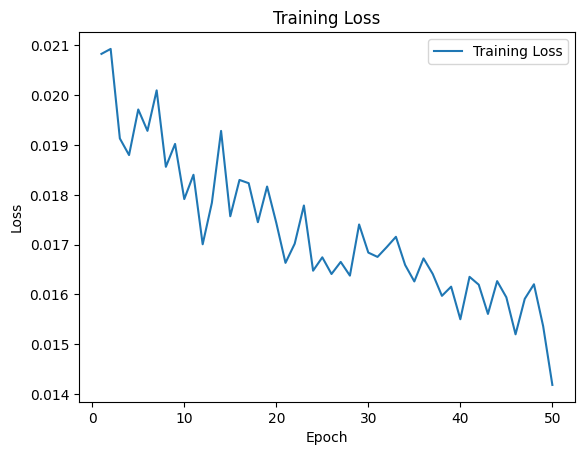

In [16]:
print_one_time=0
# Training loop
if train_loop_enable:
    train_losses = []
    num_samples = len(train_loader.dataset)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels, timesteps in train_loader:#--------------------------------

            inputs, labels, timesteps = inputs.to(device), labels.to(device), timesteps.to(device)#--------------------------------

            # Forward pass
            outputs = model(inputs)  # Shape: [batch_size, num_targets, sequence_length]
            if print_one_time==0:
                print_one_time=1
                print(inputs.shape,'ssdadasd',outputs.shape)


            # Reshape outputs and labels for MSE loss
            batch_size, num_targets, sequence_length = outputs.shape
            outputs = outputs.permute(0, 2, 1).contiguous().view(-1, num_targets)
            labels = labels.permute(0, 2, 1).contiguous().view(-1, num_targets)

            # Calculate loss using MSELoss for regression
            loss = criterion(outputs, labels)

            optimizer.zero_grad()  # Clear the gradients
            loss.backward()        # Backpropagation
            optimizer.step()       # Optimize the weights

            running_loss += loss.item()

        # Calculate and store average loss for the epoch
        train_losses.append(running_loss / (num_samples / batch_size))

        # Save the model every 10 epochs
        if (epoch + 1) % 10 == 0:
            torch.save(model.state_dict(), model_file_path)
            print(f'Model saved: {model_file_path}')

        # Print loss for this epoch
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {train_losses[-1]:.4f}')

    print('Training finished!')

    # Plot training loss
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()



Results forder make dir
---



In [17]:
results_dir = os.path.join(base_dir, "v4_mung_Data_final")
os.makedirs(results_dir, exist_ok=True)  # Tạo thư mục nếu chưa tồn tại


Result evaluation
---



In [18]:
import torch.utils.data as data
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Initialize variables
TP, number_sample = 0, 0
wrong_predictions = defaultdict(lambda: {"predicted_labels": [], "count": 0})
TP_dict, FP_dict, FN_dict, total_samples_per_label = defaultdict(int), defaultdict(int), defaultdict(int), defaultdict(int)
all_true_labels, all_predicted_labels = [], []


print_one_time=0

# Evaluate model
model.eval()
with torch.no_grad():
    for input_sequence, label, timesteps  in test_loader: #--------------------------------
        input_sequence = input_sequence.to(device)
        label = label.to(device)  # True labels are sequences, shape [batch_size, num_targets, sequence_length]
        timesteps = timesteps.to(device)#--------------------------------

        # Forward pass
        output = model(input_sequence)  # Shape: [batch_size, num_targets, sequence_length]


        # Reshape output and label to [batch_size * sequence_length, num_targets]
        batch_size, num_targets, sequence_length = output.shape


        output = output.permute(0, 2, 1).contiguous().view(-1, num_targets)  # Shape: [batch_size * sequence_length, num_targets]
        label = label.permute(0, 2, 1).contiguous().view(-1, num_targets)    # Same shape as output

        # if print_one_time==0:
        #         print_one_time=1
        #         print(label.shape,'ssdadasd',output.shape,'ÁDASDASDAS',batch_size,'jhgjhgjhg',num_targets,'khjkjhkjh',sequence_length)

        # Calculate accuracy per target
        number_sample += label.size(0)

        for i in range(label.size(0)):  # Iterate over each sample in the batch
            true_values = label[i]  # True values for the current sample
            predicted_values = output[i]  # Predicted values for the current sample
            # print(true_values)
            # print(predicted_values)
            # Tính khoảng cách Euclidean giữa true_values và predicted_values
            distance = torch.norm(true_values - predicted_values, p=2).item()  # p=2 cho khoảng cách Euclidean

            total_samples_per_label[true_values[0].item()] += 1  # Giả sử true_values[0] là label chính
            all_true_labels.append(true_values[0].item())
            all_predicted_labels.append(predicted_values[0].item())  # Chỉ dùng một giá trị cho label

            if distance <= 0.5:  # Sử dụng một ngưỡng cho việc đánh giá hồi quy
                TP += 1
                TP_dict[true_values[0].item()] += 1
            else:
                FP_dict[predicted_values[0].item()] += 1
                FN_dict[true_values[0].item()] += 1
                wrong_predictions[true_values[0].item()]["predicted_labels"].append(predicted_values.cpu().numpy())
                wrong_predictions[true_values[0].item()]["count"] += 1


# Calculate accuracy
accuracy = TP / number_sample * 100
print(f'Accuracy: {accuracy:.2f}%')

Accuracy: 94.89%


C:\Users\kaito\Documents\ML_for_PIR_array\.venv\lib\site-packages\torch\nn\modules\conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,


In [19]:
import torch.utils.data as data
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

# Khởi tạo các biến lưu kết quả
TP, number_sample = 0, 0
wrong_predictions = defaultdict(lambda: {"predicted_labels": [], "count": 0})
TP_dict, FP_dict, FN_dict, total_samples_per_label = defaultdict(int), defaultdict(int), defaultdict(int), defaultdict(int)
all_true_labels, all_predicted_labels = [], []
all_timesteps = []  # Thêm biến lưu trữ timestep cho mỗi dự đoán

# Đánh giá mô hình
model.eval()
with torch.no_grad():
    for input_sequence, label, timesteps in test_loader:  # Duyệt qua các batch trong bộ dữ liệu kiểm tra
        input_sequence = input_sequence.to(device)  # Di chuyển dữ liệu vào thiết bị (GPU/CPU)
        label = label.to(device)  # Nhãn thực sự
        timesteps = timesteps.to(device)  # Thời gian bước (timesteps)

        # Tiến hành dự đoán
        output = model(input_sequence)  # Dự đoán từ mô hình

        # Reshape output và label thành dạng [batch_size * sequence_length, num_targets]
        batch_size, num_targets, sequence_length = output.shape
        output = output.permute(0, 2, 1).contiguous().view(-1, num_targets)  # [batch_size * sequence_length, num_targets]
        label = label.permute(0, 2, 1).contiguous().view(-1, num_targets)    # [batch_size * sequence_length, num_targets]
        timesteps = timesteps.contiguous().view(-1)    # [batch_size * sequence_length]

        number_sample += label.size(0)  # Cập nhật số lượng mẫu đã đánh giá

        # print(timesteps.shape,'sdas',output.shape)
        # print(timesteps)
        
        for i in range(label.size(0)):  # Lặp qua từng mẫu trong batch
            true_values = label[i]  # Giá trị thực sự của mẫu hiện tại
            predicted_values = output[i]  # Giá trị dự đoán của mẫu hiện tại
            timestep = timesteps[i].item() # Lấy timestep của mẫu hiện tại
            

            # Tính khoảng cách Euclidean giữa true_values và predicted_values
            distance = torch.norm(true_values - predicted_values, p=2).item()  # p=2 cho khoảng cách Euclidean

            total_samples_per_label[true_values.cpu() ] += 1
            all_true_labels.append(true_values.cpu() )
            all_predicted_labels.append(predicted_values.cpu() )  # Dự đoán của mô hình
            all_timesteps.append(timestep)  # Thêm timestep vào danh sách

            if distance <= 0.35:  # Nếu khoảng cách nhỏ hơn hoặc bằng 0.5, coi là dự đoán đúng
                TP += 1
                TP_dict[true_values.cpu() ] += 1
            else:
                # Nếu khoảng cách lớn hơn 0.5, coi là sai
                FP_dict[predicted_values.cpu() ] += 1
                FN_dict[true_values.cpu() ] += 1
                wrong_predictions[true_values.cpu() ]["predicted_labels"].append(predicted_values.cpu().numpy())
                wrong_predictions[true_values.cpu() ]["count"] += 1

# Tính độ chính xác của mô hình
accuracy = TP / number_sample * 100
print(f'Accuracy: {accuracy:.2f}%')

#-------------------------------------------------------------------------------------------------------------------------
prediction_file = os.path.join(results_dir , "prediction.csv")
# os.makedirs(prediction_file, exist_ok=True)  # Tạo thư mục nếu chưa tồn tại

# Lưu kết quả vào prediction.csv
prediction_df = pd.DataFrame({
    'True Label': all_true_labels,
    'Predicted Label': all_predicted_labels,
    'Timestep': all_timesteps
})
prediction_df.to_csv(prediction_file, index=False)  # Lưu vào file CSV


wrong_predictions_list_file = os.path.join(results_dir , "wrong_predictions_list.csv")
# os.makedirs(wrong_predictions_list_file, exist_ok=True)  # Tạo thư mục nếu chưa tồn tại

# Lưu kết quả các dự đoán sai vào wrong.csv
wrong_predictions_list = []
for true_label, data in wrong_predictions.items():
    for pred_label in data["predicted_labels"]:
        wrong_predictions_list.append({
            'True Label': true_label,
            'Predicted Label': pred_label,  # Lấy giá trị dự đoán đầu tiên
            'Timestep': timestep
        })

wrong_predictions_df = pd.DataFrame(wrong_predictions_list)
wrong_predictions_df.to_csv(wrong_predictions_list_file, index=False)  # Lưu vào file CSV

print("Dữ liệu đã được lưu vào prediction.csv và wrong.csv.")

Accuracy: 87.99%
Dữ liệu đã được lưu vào prediction.csv và wrong.csv.


Mean Euclidean distance: 0.1329


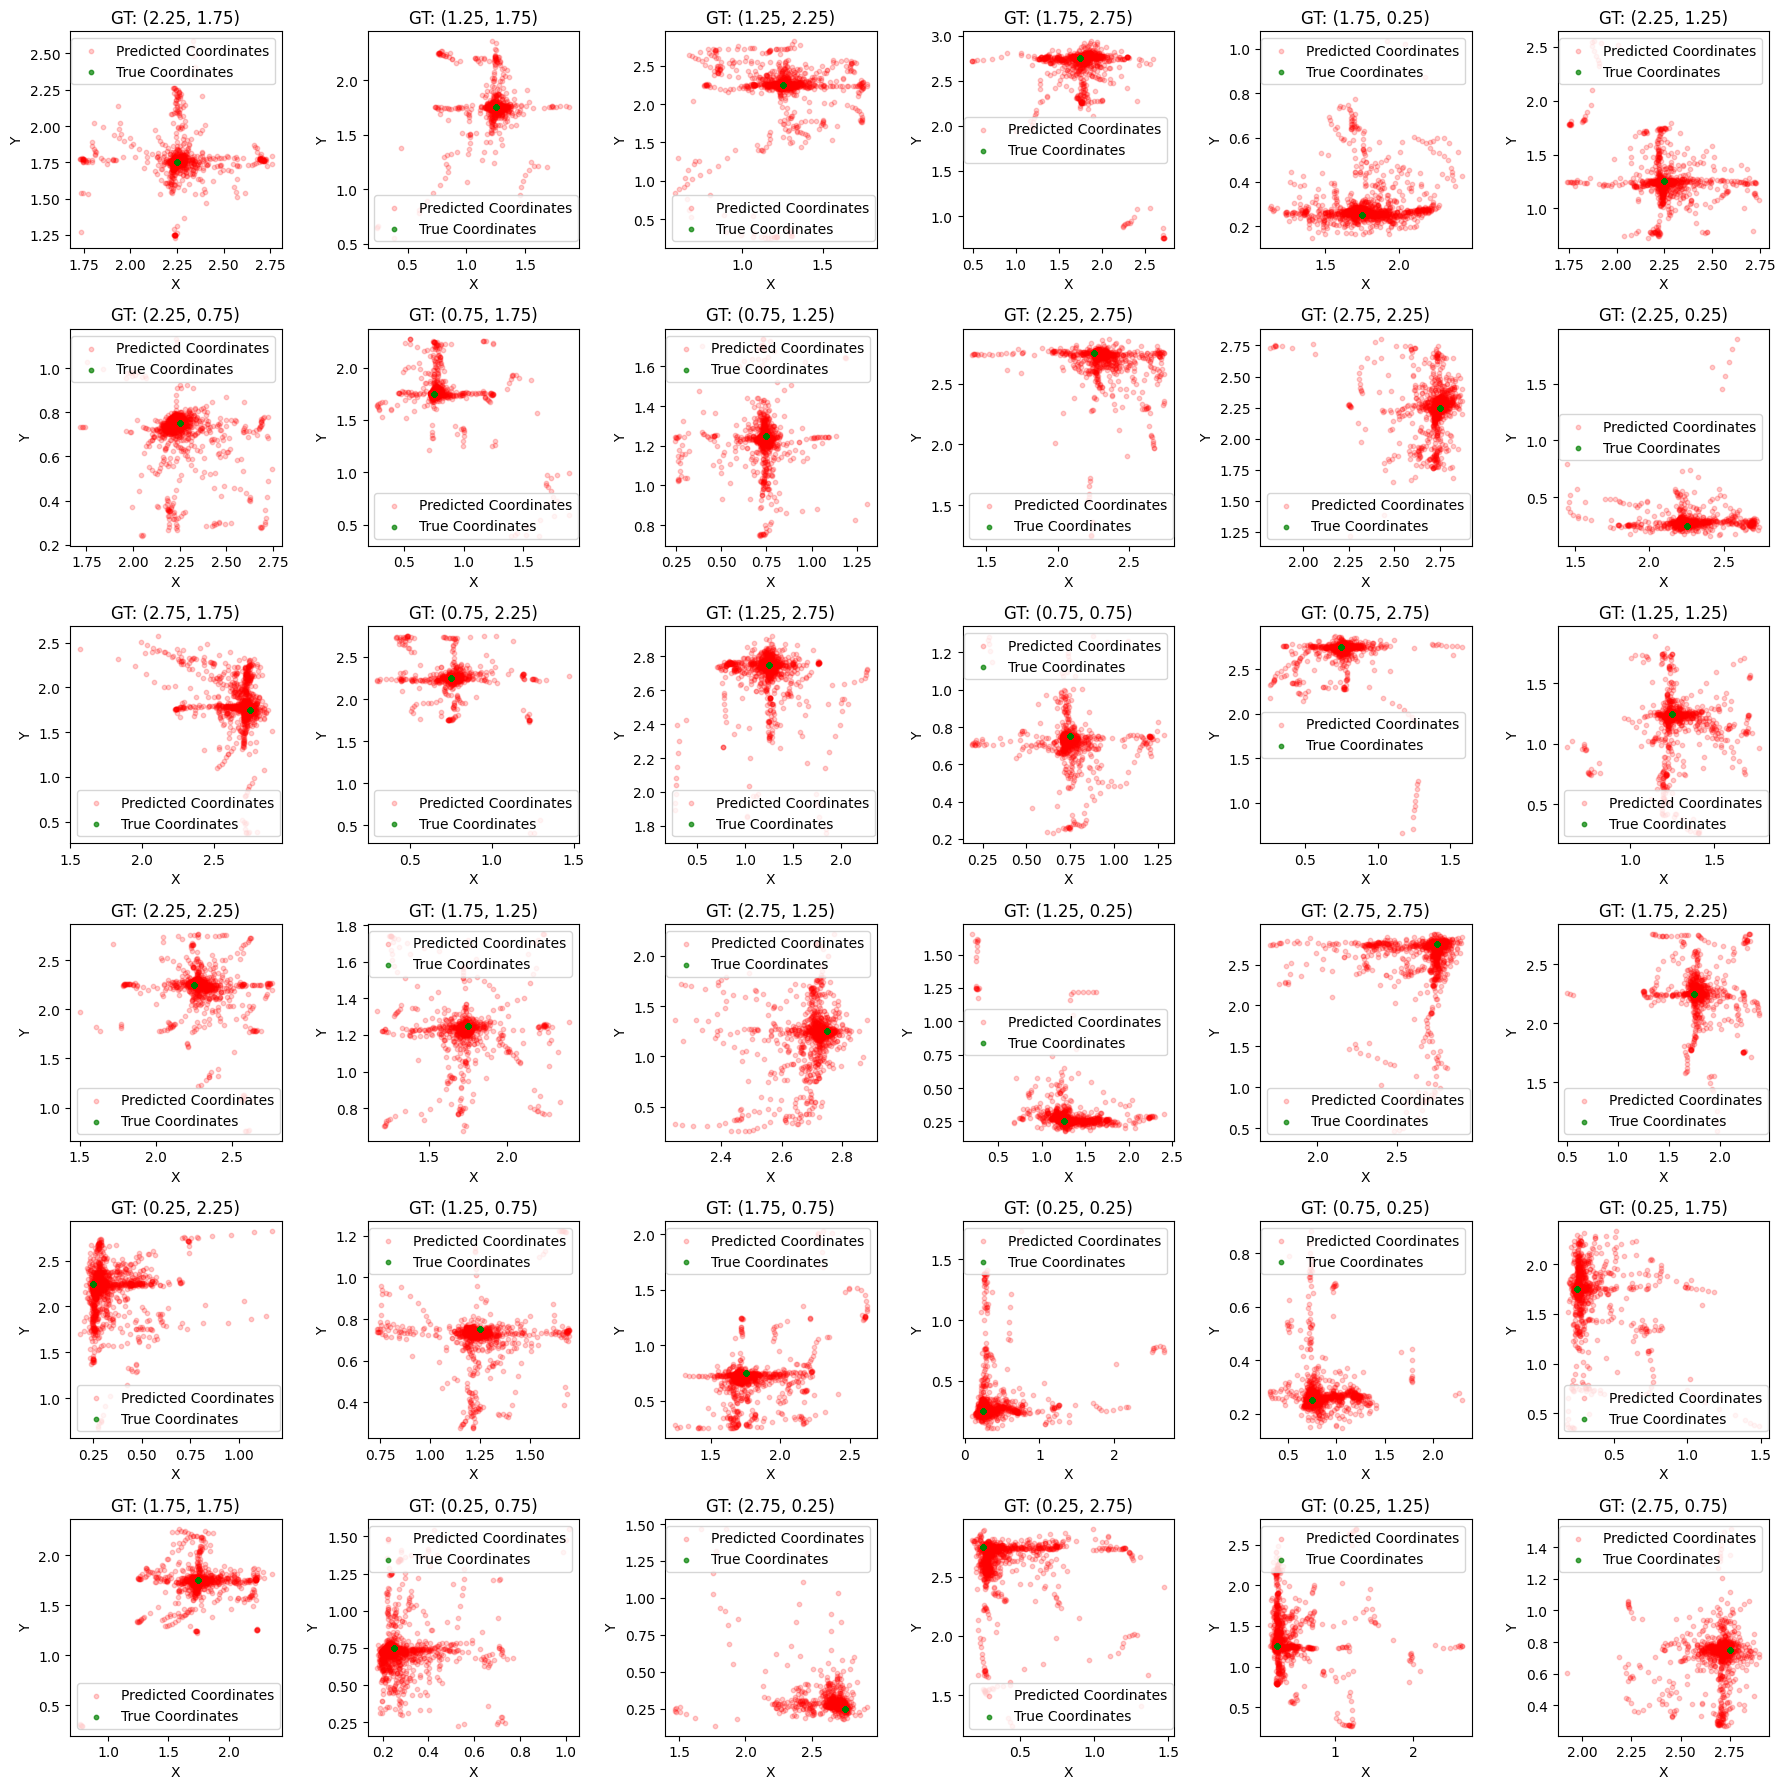

Coordinates saved to ./mung_data/Data_final\v4_mung_Data_final\coordinates_comparison.csv


In [20]:
import torch.utils.data as data
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

# Initialize variables
total_distance = 0.0
number_sample = 0
all_true_coords, all_predicted_coords = [], []
ground_truth_dict = defaultdict(lambda: {"true_coords": [], "predicted_coords": []})

print_one_time = 0

# Evaluate model
model.eval()
with torch.no_grad():
    for input_sequence, label, timesteps in test_loader:
        input_sequence = input_sequence.to(device)
        label = label.to(device)  # True labels are sequences of coordinates, shape [batch_size, num_targets, sequence_length]

        # Forward pass
        output = model(input_sequence)  # Predicted coordinates, shape [batch_size, num_targets, sequence_length]

        # Reshape output and label to [batch_size * sequence_length, num_targets]
        batch_size, num_targets, sequence_length = output.shape
        # if print_one_time == 0:
        #     print_one_time = 1
        #     print(label.shape, 'ssdadasd', output.shape)

        output = output.permute(0, 2, 1).contiguous().view(-1, num_targets)  # Shape: [batch_size * sequence_length, num_targets]
        label = label.permute(0, 2, 1).contiguous().view(-1, num_targets)    # Same shape as output

        # Calculate distance for x and y coordinates
        for i in range(label.size(0)):  # Iterate over each timestep
            true_values = label[i]  # True coordinates for the current timestep (x, y)
            predicted_values = output[i]  # Predicted coordinates for the current timestep (x, y)

            # Calculate Euclidean distance between true and predicted coordinates
            distance = torch.norm(true_values - predicted_values).item()  # Calculate distance

            total_distance += distance

            # Store true and predicted coordinates for plotting
            all_true_coords.append(true_values.cpu().numpy())
            all_predicted_coords.append(predicted_values.cpu().numpy())

            # Group by true coordinates for plotting later
            ground_truth_dict[(true_values[0].item(), true_values[1].item())]["true_coords"].append(true_values.cpu().numpy())
            ground_truth_dict[(true_values[0].item(), true_values[1].item())]["predicted_coords"].append(predicted_values.cpu().numpy())

        # Count the number of samples (each timestep contributes one sample)
        number_sample += label.size(0)

# Calculate average distance
mean_distance = total_distance / number_sample
print(f'Mean Euclidean distance: {mean_distance:.4f}')

# Plot true vs predicted coordinates for each ground truth using subplot 6x6
fig, axes = plt.subplots(6, 6, figsize=(18, 18))
axes = axes.flatten()  # Flatten the 6x6 grid for easy iteration

for idx, ((true_x, true_y), coords) in enumerate(ground_truth_dict.items()):
    true_coords = np.array(coords["true_coords"])
    predicted_coords = np.array(coords["predicted_coords"])

    ax = axes[idx]
    ax.scatter(predicted_coords[:, 0], predicted_coords[:, 1], label='Predicted Coordinates', color='red', alpha=0.2,s=10)
    ax.scatter(true_coords[:, 0], true_coords[:, 1], label='True Coordinates', color='green', alpha=0.7,s=10)
    ax.set_title(f'GT: ({true_x:.2f}, {true_y:.2f})')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.legend()

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

# # Save the true and predicted coordinates to a file for further analysis
coords_file = os.path.join(results_dir, "coordinates_comparison.csv")
# os.makedirs(coords_file, exist_ok=True)  # Tạo thư mục nếu chưa tồn tại

with open(coords_file, 'w') as file:
    file.write('True_X,True_Y,Predicted_X,Predicted_Y\n')
    for true_coord, pred_coord in zip(all_true_coords, all_predicted_coords):
        file.write(f'{true_coord[0]},{true_coord[1]},{pred_coord[0]},{pred_coord[1]}\n')
print(f'Coordinates saved to {coords_file}')


Function for process testdata
---



In [21]:
# ______________________________Sec1____________________________________________
def calculate_area(signal, threshold=0):
    # Tính phần diện tích dưới đường cong và trục y=threshold
    diff_signal = signal - threshold

    # Tính diện tích sử dụng quy tắc hình thang
    area = torch.sum(torch.abs((diff_signal[:, :-1] + diff_signal[:, 1:]) / 2), dim=1)

    return area

def check_area(signals, threshold=0, area_threshold=1.5):
    # Tính diện tích cho từng sensor
    areas = calculate_area(signals, threshold)

    # # In ra diện tích của từng sensor
    # for i, area in enumerate(areas):
    #     print(f"Diện tích của sensor {i + 1}: {area.item()}")

    # Tính tổng diện tích của 5 sensor
    total_area = torch.sum(areas)
    # print(f"Tổng diện tích: {total_area.item()}")

    # Kiểm tra tổng diện tích có lớn hơn area_threshold không
    return total_area > area_threshold

# # Giả sử tín hiệu đầu vào dạng torch size (1,5,10)
# signals_list = [
#     [2.05,2.05,2.05,2.05,2.03,2.04,2.04,2.04,2.05,2.05],
#     [2.05,2.05,2.06,2.06,2.06,2.08,2.07,2.07,2.07,2.07],
#     [2.05,2.04,2.03,2.05,2.04,2.04,2.04,2.05,2.05,2.05],
#     [2.04,2.04,2.04,2.05,2.07,2.05,2.05,2.05,2.06,2.05],
#     [2.07,2.06,2.05,2.05,2.04,2.06,2.05,2.06,2.06,2.06]
# ]

# # Chuyển đổi signals_list thành tensor PyTorch
# signals = torch.tensor(signals_list, dtype=torch.float32)
# print(signals)
# # Kiểm tra diện tích
# result = check_area(signals)
# print(f"Kết quả: {result}")
# ______________________________Sec2____________________________________________
def is_adjacent(coord1, coord2):
    """Check if two coordinates are adjacent in the 3x3 grid."""
    if coord1 is None or coord2 is None:
        return False
    row_diff = abs(coord1[0] - coord2[0])
    col_diff = abs(coord1[1] - coord2[1])
    return row_diff <= 1 and col_diff <= 1

import numpy as np

def correct_labels(coordinates):
    """Correct the sequence of coordinates if they are not adjacent."""
    # Chuyển đổi coordinates thành mảng numpy để dễ thao tác
    coordinates = np.array(coordinates)

    corrected_y1 = coordinates[:, 0].copy()
    corrected_y2 = coordinates[:, 1].copy()
    previous_coords = None

    # First pass: fix non-adjacent coordinates
    for i, (y1, y2) in enumerate(zip(coordinates[:, 0], coordinates[:, 1])):
        if y1 == 0 and y2 == 0:
            continue

        current_coords = (y1, y2)  # y1 và y2 đã là tọa độ
        if previous_coords and not is_adjacent(previous_coords, current_coords):
            corrected_y1[i], corrected_y2[i] = corrected_y1[i-1], corrected_y2[i-1]
        previous_coords = current_coords if (y1 != 0 or y2 != 0) else previous_coords

    # Trả về danh sách các tọa độ (y1, y2) đã được điều chỉnh
    return list(zip(corrected_y1.tolist(), corrected_y2.tolist()))




def process_labels(correct_labels):
    """Process labels by replacing (0, 0) with the last non-(0, 0) label."""
    processed_labels = []
    waiting_zero = 0

    for label in correct_labels:
        if label == (0, 0):
            if len(processed_labels) > 0 and processed_labels[-1] != (0, 0):
                processed_labels.append(processed_labels[-1])
            else:
                waiting_zero += 1
        else:
            if waiting_zero > 0:
                # Thay thế tất cả các nhãn (0, 0) đã chờ bằng nhãn không phải (0, 0) cuối cùng
                processed_labels.extend([label] * (waiting_zero + 1))
                waiting_zero = 0
            else:
                processed_labels.append(label)

    return processed_labels


# ______________________________Sec3____________________________________________

# Hàm vẽ đường đi từ danh sách tọa độ
def plot_path(coordinates):
    # Tách tọa độ x và y từ danh sách tọa độ
    x_coords, y_coords = zip(*coordinates)

    # Vẽ đường đi
    plt.plot(x_coords, y_coords, marker='o', linestyle='-')

    # Đặt tiêu đề và nhãn trục
    plt.title('Đường đi')
    plt.xlabel('Tọa độ x')
    plt.ylabel('Tọa độ y')

    # Hiển thị đồ thị
    plt.grid(True)
    plt.show()

# Hàm vẽ đường đi từ danh sách tọa độ

# Danh sách màu sắc
colors = ['red', 'blue', 'yellow', 'green', 'orange', 'purple', 'cyan', 'magenta']

def mul_plot_path(coordinates):
    if not coordinates:
        print("Danh sách tọa độ trống!")
        return

    # Kiểm tra xem có một hoặc nhiều xâu tọa độ
    if isinstance(coordinates[0], tuple):
        coordinates = [coordinates]  # Nếu chỉ có một xâu tọa độ, chuyển đổi thành danh sách có một phần tử

    # Lặp qua từng xâu tọa độ và vẽ
    for i, coord_set in enumerate(coordinates):
        # Tách tọa độ x và y từ danh sách tọa độ
        x_coords, y_coords = zip(*coord_set)

        # Chọn màu dựa trên chỉ số
        color = colors[i % len(colors)]  # Sử dụng modulo để quay lại màu nếu có nhiều hơn số màu

        # Vẽ đường đi với màu khác nhau cho mỗi xâu tọa độ
        plt.plot(x_coords, y_coords, marker='o', c=color, linestyle='-', alpha=0.5, label=f'Path {i+1}')

    # Đặt tiêu đề và nhãn trục
    plt.title('Đường đi')
    plt.xlabel('Tọa độ x')
    plt.ylabel('Tọa độ y')

    # Hiển thị đồ thị và chú thích
    plt.legend()
    plt.grid(True)
    plt.axis([0,3,0,3])
    plt.show()

# Hàm vẽ từng điểm từ danh sách tọa độ
def mul_plot_points(coordinates):
    if not coordinates:
        print("Danh sách tọa độ trống!")
        return

    # Kiểm tra xem có một hoặc nhiều xâu tọa độ
    if isinstance(coordinates[0], tuple):
        coordinates = [coordinates]  # Nếu chỉ có một xâu tọa độ, chuyển đổi thành danh sách có một phần tử

    # Lặp qua từng xâu tọa độ và vẽ từng điểm
    for i, coord_set in enumerate(coordinates):
        # Tách tọa độ x và y từ danh sách tọa độ
        x_coords, y_coords = zip(*coord_set)

        # Chọn màu dựa trên chỉ số
        color = colors[i % len(colors)]  # Sử dụng modulo để quay lại màu nếu có nhiều hơn số màu

        # Vẽ các điểm với màu khác nhau cho mỗi xâu tọa độ
        plt.scatter(x_coords, y_coords, s=10, c=color, marker='o', alpha=0.3, label=f'Points {i+1}')

    # Đặt tiêu đề và nhãn trục
    plt.title('Các điểm tọa độ')
    plt.xlabel('Tọa độ x')
    plt.ylabel('Tọa độ y')

    # Hiển thị đồ thị và chú thích
    plt.legend()
    plt.grid(True)
    plt.axis([0, 3, 0, 3])  # Bạn có thể thay đổi giới hạn trục nếu cần
    plt.show()


Import test data
---



In [22]:
import os
import numpy as np
import pandas as pd
import torch

# Đường dẫn thư mục chính
base_dir = "./mung_data/testcase1812"

padding_x = 0
offset_x_value=1500

batch_name = []

# Khởi tạo danh sách lưu dữ liệu từ các thư mục cấp 1
x_test = []
y_test = []
y_xy_test = []

# Tạo danh sách các thư mục cấp 1
level_1_dirs = sorted([d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))])

for l1_idx, l1_dir in enumerate(level_1_dirs):
    l1_path = os.path.join(base_dir, l1_dir)
    print(f"Đang xử lý thư mục: {l1_dir}")

    # Duyệt qua các file CSV trong thư mục cấp 2
    csv_files = sorted([f for f in os.listdir(l1_path) if f.endswith(".csv")])
    for file in csv_files:
        file_path = os.path.join(l1_path, file)
        print(f"    Đang xử lý file CSV: {file}")

        # Đọc và xử lý file CSV
        try:
            data = pd.read_csv(file_path, header=None)
            if data.empty:
                print(f'file {file} trống bỏ qua')
                continue

            # Danh sách lưu dòng hợp lệ
            valid_x = []
            valid_y = []
            valid_y_xy = []

            # Duyệt qua từng dòng của file
            for idx, row in data.iterrows():
                try:
                    # Lấy giá trị x và y từ dòng
                    x = row[1:6].values-offset_x_value # 5 cột
                    y = row[6]  # Nhãn

                    # Chuyển đổi nhãn nếu cần
                    if isinstance(y, str) and y.startswith('id'):
                        try:
                            # Lấy phần số sau 'id'
                            num_part = int(y[2:])
                            if num_part != 0:
                                y = int(num_part)  # Chuyển thành số thực
                                y_xy=label_to_xy(y,area)
                            else:
                                # print(f"    Nhãn 'id{num_part}' không hợp lệ, bỏ qua.")
                                continue
                        except ValueError:
                            print(f"    Nhãn '{y}' không thể chuyển đổi, bỏ qua.")
                            continue

                    # Loại bỏ dòng nếu y vẫn không hợp lệ
                    if pd.isna(y):
                        print(f"    Dòng {idx} không hợp lệ, bỏ qua.")
                        continue

                    # Lưu dòng hợp lệ
                    valid_x.append(x)
                    valid_y.append(y)
                    valid_y_xy.append(y_xy)

                except Exception as e:
                    print(f"    Lỗi khi xử lý dòng {idx}: {e}")

            # Chuyển danh sách thành numpy array
            valid_x = np.array(valid_x).T
            valid_y = np.array(valid_y).T
            valid_y_xy = np.array(valid_y_xy).T

            # Thêm vào danh sách cấp 2
            x_test.append(valid_x)
            y_test.append(valid_y)  # Đảm bảo y có 2 chiều (số dòng, 1)
            y_xy_test.append(valid_y_xy)  # Đảm bảo y có 2 chiều (số dòng, 1)

        except Exception as e:
            print(f"Lỗi khi xử lý file {file_path}: {e}")
#------------------------------------------------------------------------------------------------
filtered_x_test=[]
for i in range(len(x_test)):
    filtered_x_test.append(noise_filter(x_test[i]))
print("da loc x_test")
x_test=filtered_x_test
#------------------------------------------------------------------------------------------------

x_sc_list=[]
y_sc_list=[]
y_xy_sc_list=[]

for i in range(len(x_test)):
    # Chuyển đổi sang PyTorch tensors
    # x = np.array(x_test[i], dtype=float)  # Đảm bảo tất cả phần tử là float v1
    x = np.array(noise_filter(x_test[i]), dtype=float)  # Đảm bảo tất cả phần tử là float v2
    y_xy = np.array(y_xy_test[i], dtype=float)  # Đảm bảo tất cả phần tử là float v2
    y = np.array(y_test[i], dtype=int)  # Tương tự

    x_tensor_test = torch.tensor(x, dtype=torch.float32)  # Kích thước: (số lát cắt, step)
    y_tensor_test = torch.tensor(y, dtype=torch.int)  # Kích thước: (số lát cắt, step)
    y_xy_tensor_test = torch.tensor(y_xy, dtype=torch.float32)  # Kích thước: (số lát cắt, step)
    x_sc_list.append(x_tensor_test)
    # y_sc_list.append(y_tensor_test)
    y_sc_list.append(y_xy_tensor_test)

Đang xử lý thư mục: testcase1
    Đang xử lý file CSV: 1734527778996-1734527810034.csv
    Đang xử lý file CSV: 1734527830628-1734527861884.csv
    Đang xử lý file CSV: 1734527870919-1734527902219.csv
Đang xử lý thư mục: testcase2
    Đang xử lý file CSV: 1734527923084-1734527957426.csv
    Đang xử lý file CSV: 1734527976733-1734528008005.csv
    Đang xử lý file CSV: 1734528017855-1734528053746.csv
Đang xử lý thư mục: testcase3
    Đang xử lý file CSV: 1734528075933-1734528118816.csv
    Đang xử lý file CSV: 1734528128955-1734528170679.csv
    Đang xử lý file CSV: 1734528182138-1734528224651.csv
Đang xử lý thư mục: testcase4
    Đang xử lý file CSV: 1734528248398-1734528289443.csv
    Đang xử lý file CSV: 1734528297002-1734528341248.csv
    Đang xử lý file CSV: 1734528353818-1734528395109.csv
da loc x_test


Predict and visual testdata (All scenarios)
---



Kịch bản 1
Data written to ./result compare/v4/ket_qua_test_v4/output_kich_ban_1.csv
Khoảng cách trung bình: 0.4680899109871727


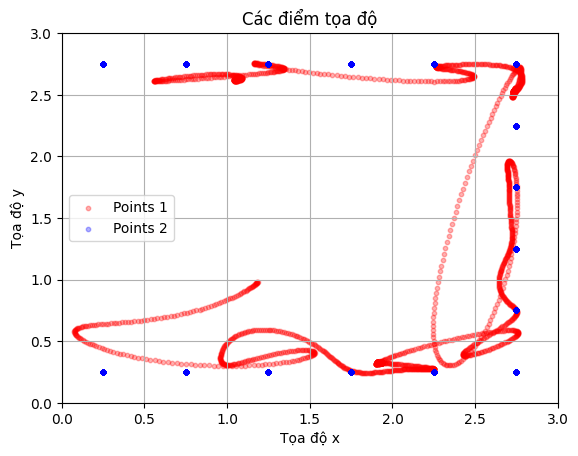

Kịch bản 2
Data written to ./result compare/v4/ket_qua_test_v4/output_kich_ban_2.csv
Khoảng cách trung bình: 0.39955740556731506


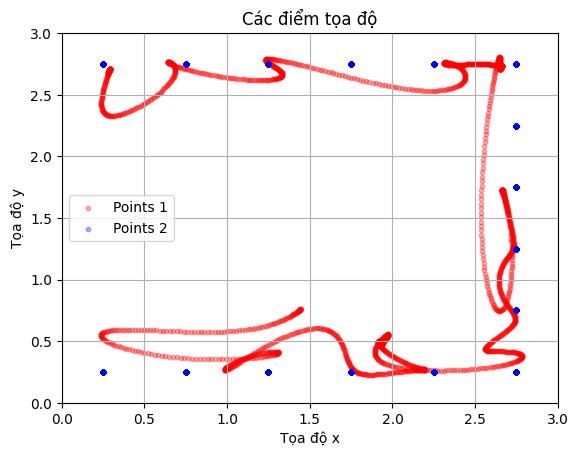

Kịch bản 3
Data written to ./result compare/v4/ket_qua_test_v4/output_kich_ban_3.csv
Khoảng cách trung bình: 0.733579401368733


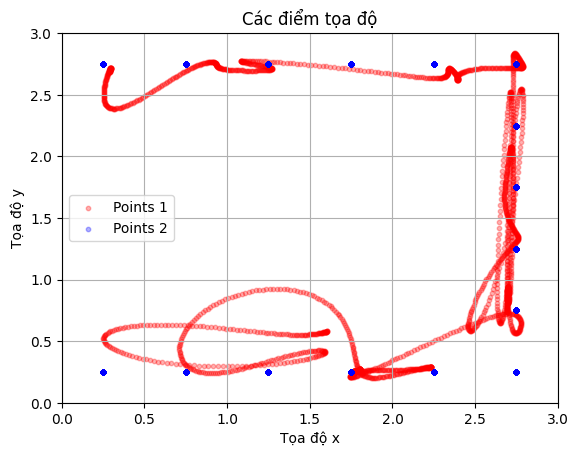

Kịch bản 4
Data written to ./result compare/v4/ket_qua_test_v4/output_kich_ban_4.csv
Khoảng cách trung bình: 0.5047782914129686


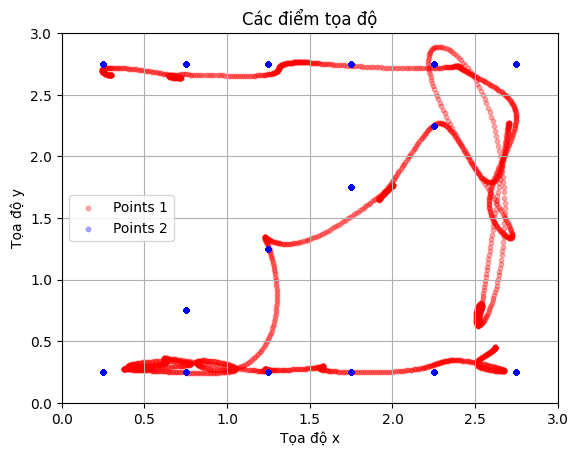

Kịch bản 5
Data written to ./result compare/v4/ket_qua_test_v4/output_kich_ban_5.csv
Khoảng cách trung bình: 0.28048262960560433


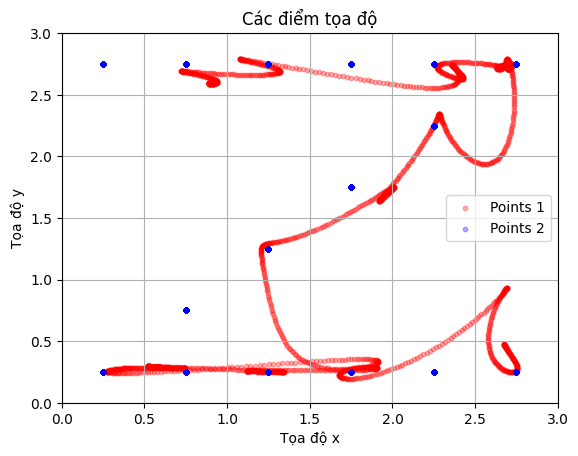

Kịch bản 6
Data written to ./result compare/v4/ket_qua_test_v4/output_kich_ban_6.csv
Khoảng cách trung bình: 0.7274469453925794


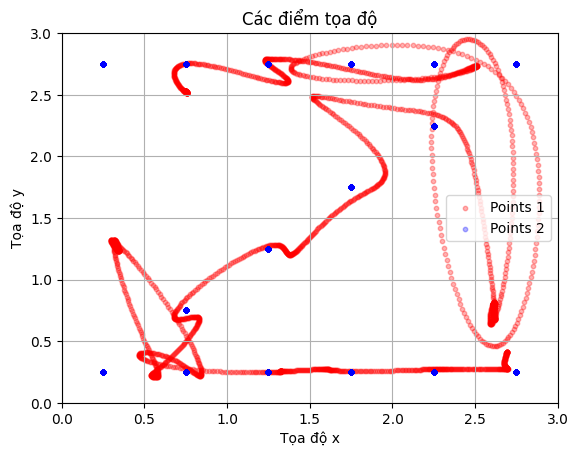

Kịch bản 7
Data written to ./result compare/v4/ket_qua_test_v4/output_kich_ban_7.csv
Khoảng cách trung bình: 0.5351946847531253


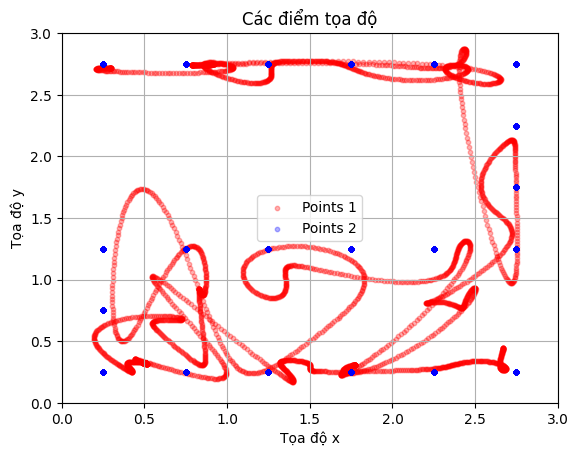

Kịch bản 8
Data written to ./result compare/v4/ket_qua_test_v4/output_kich_ban_8.csv
Khoảng cách trung bình: 0.38809499083967886


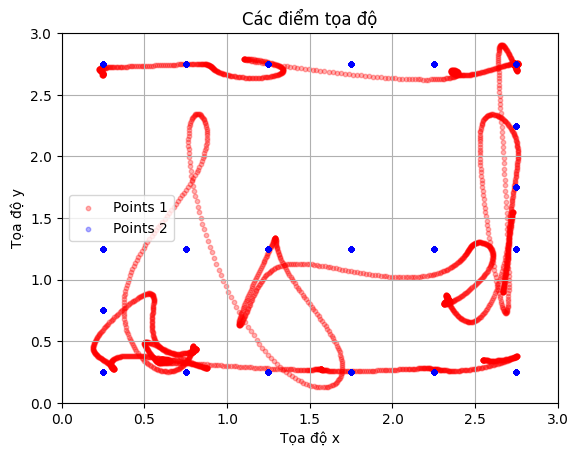

Kịch bản 9
Data written to ./result compare/v4/ket_qua_test_v4/output_kich_ban_9.csv
Khoảng cách trung bình: 0.45382439256071966


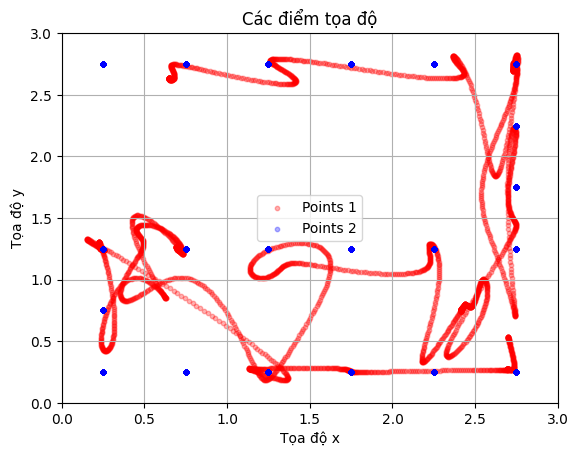

Kịch bản 10
Data written to ./result compare/v4/ket_qua_test_v4/output_kich_ban_10.csv
Khoảng cách trung bình: 0.7511304355035288


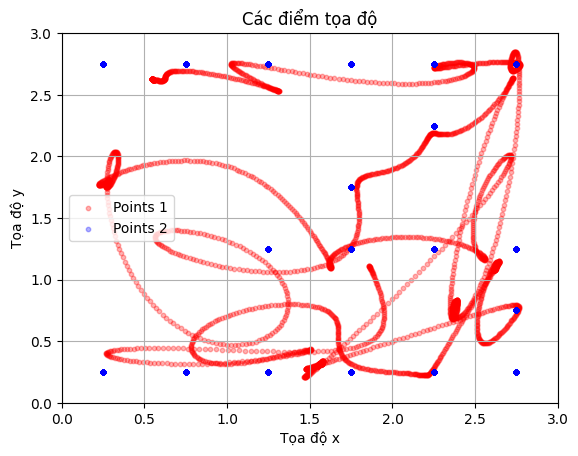

Kịch bản 11
Data written to ./result compare/v4/ket_qua_test_v4/output_kich_ban_11.csv
Khoảng cách trung bình: 0.6112531002012792


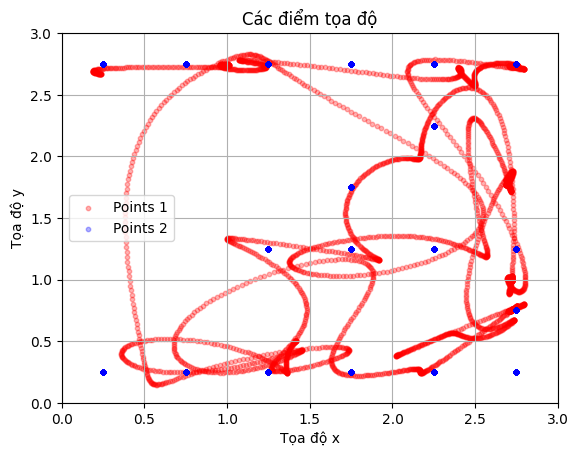

Kịch bản 12
Data written to ./result compare/v4/ket_qua_test_v4/output_kich_ban_12.csv
Khoảng cách trung bình: 0.47138452988602536


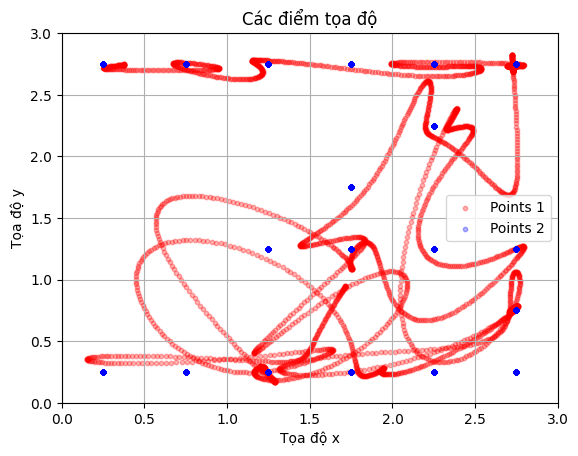

In [29]:
# Ví dụ về window_size nếu cần
window_size = sequence_length

#chuyen sang che do danh gia
model.eval()

#----------------------------------------------------------------------------------------------------------------------------------------------
# Chọn kịch bản
for sc_index in range(len(y_sc_list)):
    print('Kịch bản', sc_index + 1)
    X_test = x_sc_list[sc_index]
    Y_test = y_sc_list[sc_index]

    # Số lượng cửa sổ có thể tạo ra từ dữ liệu test
    num_windows = X_test.shape[1] // window_size
    window_residual = X_test.shape[1] % window_size
    if window_residual:
        num_windows += 1

    best_threshold = 1500

    predictions = []
    sample = X_test
    sample_windows = []
    for i in range(num_windows):
        window = sample[:, i * window_size: (i + 1) * window_size].unsqueeze(0)
        check = check_area(window[0], area_threshold=best_threshold)
        if check:
            model.eval()
            with torch.no_grad():
                output = model(window.to(device))
            # Dự đoán cho y1 và y2
            predicted_values = output.squeeze(0).permute(1,0)  # Kích thước [2, 10]
            for t in range(predicted_values.shape[0]):  # Duyệt qua từng timestep
                y1, y2 = predicted_values[t].tolist()  # Lấy tọa độ cho timestep t
                sample_windows.append((y1, y2))  # Thêm tuple (y1, y2)
        else:
            sample_windows.extend([(0, 0)] * window_size)  # Dự đoán mặc định
        predictions.append(sample_windows)

    # Duyệt qua kết quả dự đoán
    prediction_raw=predictions[0]
    corrected_labels = correct_labels(prediction_raw)  # Điều chỉnh lại nhãn nếu cần
    # processed_labels = process_labels(corrected_labels)
    processed_labels = process_labels(prediction_raw)
    # print(np.array(processed_labels).T.shape)

            
    processed_labels = noise_filter(np.array(processed_labels).T,100,1).T#############################################################################
    
    
    # Giả sử Y_test có kích thước (1, 2) và bạn cần truy cập vào y1 và y2
    y1_ground_truth = [x for x in Y_test[0].tolist()]  # Lấy giá trị y1
    y2_ground_truth = [x for x in Y_test[1].tolist()]  # Lấy giá trị y2
    # print(y1_ground_truth,'   ',y2_ground_truth)

    # Tạo một danh sách chứa tọa độ (y1, y2) từ các giá trị y1 và y2
    int_list = list(zip(y1_ground_truth, y2_ground_truth))

    # Trim và ghi dữ liệu ra file như trước
    min_length = len(int_list)
    trimmed_prediction_raw = prediction_raw[:min_length]
    trimmed_corrected_labels = corrected_labels[:min_length]
    trimmed_processed_labels = processed_labels[:min_length]
#----------------------------------------------------------------------------------------------------------------------------------------------
    import os
    import csv
    # Specify the file path
    file_path = f'./result compare/v4/ket_qua_test_v4/output_kich_ban_{sc_index + 1}.csv'

    # Create the directory if it doesn't exist
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Open the file in write mode
    with open(file_path, mode='w', newline='') as file:
        writer = csv.writer(file)

        # Write the header
        writer.writerow(['Corrected Labels', 'Processed Labels', 'Ground', 'Raw'])

        # Write the data rows
        for c_label, p_label, i_val, r_val in zip(trimmed_corrected_labels, trimmed_processed_labels, int_list, trimmed_prediction_raw):
            writer.writerow([c_label, p_label, i_val, r_val])

    print(f"Data written to {file_path}")
#----------------------------------------------------------------------------------------------------------------------------------------------
    # Chuyển đổi các nhãn từ danh sách 1D sang danh sách tọa độ 2D (x, y)
    # y_true_xy = compute_group_coordinates(most_frequent_in_sliding_window(int_list, k=60, s=60,padding=0), area, k=1)
    y_true_xy = int_list
    # print(y_true_xy)
    y_pred_xy = trimmed_processed_labels

    # Tính khoảng cách Euclidean giữa các cặp tọa độ và tính khoảng cách trung bình
    distances = [np.linalg.norm(np.array(true_xy) - np.array(pred_xy)) for true_xy, pred_xy in zip(y_true_xy, y_pred_xy)]
    mean_distance = np.mean(distances)
    

    print("Khoảng cách trung bình:", mean_distance)
    # print("Khoảng cách trung bình:", best_distance)

    # Vẽ đường đi từ danh sách tọa độ
    mul_plot_points([y_pred_xy,y_true_xy])
    # mul_plot_path([y_pred_xy,y_true_xy])

Random test
---



In [16]:
import os
import numpy as np
import pandas as pd
import torch

# Đường dẫn thư mục chính
base_dir = "./mung_data/ngau_nhien_da_co csv_Data_final"

padding_x = 0
offset_x_value=1500

batch_name = []

# Khởi tạo danh sách lưu dữ liệu từ các thư mục cấp 1
x_test = []
y_test = []
y_xy_test = []

# Tạo danh sách các thư mục cấp 1
level_1_dirs = sorted([d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))])

for l1_idx, l1_dir in enumerate(level_1_dirs):
    l1_path = os.path.join(base_dir, l1_dir)
    print(f"Đang xử lý thư mục: {l1_dir}")

    # Duyệt qua các file CSV trong thư mục cấp 2
    csv_files = sorted([f for f in os.listdir(l1_path) if f.endswith(".csv")])
    for file in csv_files:
        file_path = os.path.join(l1_path, file)
        print(f"    Đang xử lý file CSV: {file}")

        # Đọc và xử lý file CSV
        try:
            data = pd.read_csv(file_path, header=None)
            if data.empty:
                print(f'file {file} trống bỏ qua')
                continue

            # Danh sách lưu dòng hợp lệ
            valid_x = []
            valid_y = []
            valid_y_xy = []

            # Duyệt qua từng dòng của file
            for idx, row in data.iterrows():
                try:
                    # Lấy giá trị x và y từ dòng
                    x = row[1:6].values-offset_x_value # 5 cột
                    y = row[6]  # Nhãn

                    # # Chuyển đổi nhãn nếu cần
                    # if isinstance(y, str) and y.startswith('id'):
                    #     try:
                    #         # Lấy phần số sau 'id'
                    #         num_part = int(y[2:])
                    #         if num_part != 0:
                    #             y = int(num_part)  # Chuyển thành số thực
                    #             y_xy=label_to_xy(y,area)
                    #         else:
                    #             # print(f"    Nhãn 'id{num_part}' không hợp lệ, bỏ qua.")
                    #             continue
                    #     except ValueError:
                    #         print(f"    Nhãn '{y}' không thể chuyển đổi, bỏ qua.")
                    #         continue

                    # Loại bỏ dòng nếu y vẫn không hợp lệ
                    if pd.isna(y):
                        print(f"    Dòng {idx} không hợp lệ, bỏ qua.")
                        continue

                    # Lưu dòng hợp lệ
                    valid_x.append(x)
                    valid_y.append(y)
                    valid_y_xy.append(y_xy)

                except Exception as e:
                    print(f"    Lỗi khi xử lý dòng {idx}: {e}")

            # Chuyển danh sách thành numpy array
            valid_x = np.array(valid_x).T
            valid_y = np.array(valid_y).T
            valid_y_xy = np.array(valid_y_xy).T

            # Thêm vào danh sách cấp 2
            x_test.append(valid_x)
            y_test.append(valid_y)  # Đảm bảo y có 2 chiều (số dòng, 1)
            y_xy_test.append(valid_y_xy)  # Đảm bảo y có 2 chiều (số dòng, 1)

        except Exception as e:
            print(f"Lỗi khi xử lý file {file_path}: {e}")
#------------------------------------------------------------------------------------------------
filtered_x_test=[]
for i in range(len(x_test)):
    filtered_x_test.append(noise_filter(x_test[i]))
print("da loc x_test")
x_test=filtered_x_test
#------------------------------------------------------------------------------------------------

x_sc_list=[]
y_sc_list=[]
y_xy_sc_list=[]

for i in range(len(x_test)):
    # Chuyển đổi sang PyTorch tensors
    # x = np.array(x_test[i], dtype=float)  # Đảm bảo tất cả phần tử là float v1
    x = np.array(noise_filter(x_test[i]), dtype=float)  # Đảm bảo tất cả phần tử là float v2
    # y_xy = np.array(y_xy_test[i], dtype=float)  # Đảm bảo tất cả phần tử là float v2
    # y = np.array(y_test[i], dtype=int)  # Tương tự

    x_tensor_test = torch.tensor(x, dtype=torch.float32)  # Kích thước: (số lát cắt, step)
    # y_tensor_test = torch.tensor(y, dtype=torch.int)  # Kích thước: (số lát cắt, step)
    # y_xy_tensor_test = torch.tensor(y_xy, dtype=torch.float32)  # Kích thước: (số lát cắt, step)
    x_sc_list.append(x_tensor_test)
    # y_sc_list.append(y_tensor_test)
    # y_sc_list.append(y_xy_tensor_test)

Đang xử lý thư mục: case
    Đang xử lý file CSV: 1734528704401-1734528764181.csv
    Đang xử lý file CSV: 1734528827921-1734528872124.csv
    Đang xử lý file CSV: 1734528898040-1734528940590.csv
    Đang xử lý file CSV: 1734528983421-1734529023931.csv
da loc x_test


In [1]:
# Ví dụ về window_size nếu cần
window_size = sequence_length

#chuyen sang che do danh gia
model.eval()

#----------------------------------------------------------------------------------------------------------------------------------------------
# Chọn kịch bản
for sc_index in range(4):
    print('Kịch bản', sc_index + 1)
    X_test = x_sc_list[sc_index]
    # Y_test = y_sc_list[sc_index]

    # Số lượng cửa sổ có thể tạo ra từ dữ liệu test
    num_windows = X_test.shape[1] // window_size
    window_residual = X_test.shape[1] % window_size
    if window_residual:
        num_windows += 1

    best_threshold = 4000

    predictions = []
    sample = X_test
    sample_windows = []
    for i in range(num_windows):
        window = sample[:, i * window_size: (i + 1) * window_size].unsqueeze(0)
        check = check_area(window[0], area_threshold=best_threshold)
        if check:
            model.eval()
            with torch.no_grad():
                output = model(window.to(device))
            # Dự đoán cho y1 và y2
            predicted_values = output.squeeze(0).permute(1,0)  # Kích thước [2, 10]
            for t in range(predicted_values.shape[0]):  # Duyệt qua từng timestep
                y1, y2 = predicted_values[t].tolist()  # Lấy tọa độ cho timestep t
                sample_windows.append((y1, y2))  # Thêm tuple (y1, y2)
        else:
            sample_windows.extend([(0, 0)] * window_size)  # Dự đoán mặc định
        predictions.append(sample_windows)

    # Duyệt qua kết quả dự đoán
    prediction_raw=predictions[0]
    corrected_labels = correct_labels(prediction_raw)  # Điều chỉnh lại nhãn nếu cần
    # processed_labels = process_labels(corrected_labels)
    processed_labels = process_labels(prediction_raw)
    # print(np.array(processed_labels).T.shape)

            
    processed_labels = noise_filter(np.array(processed_labels).T,100,0.4).T
    
    
    # # Giả sử Y_test có kích thước (1, 2) và bạn cần truy cập vào y1 và y2
    # y1_ground_truth = [x for x in Y_test[0].tolist()]  # Lấy giá trị y1
    # y2_ground_truth = [x for x in Y_test[1].tolist()]  # Lấy giá trị y2
    # print(y1_ground_truth,'   ',y2_ground_truth)

    # Tạo một danh sách chứa tọa độ (y1, y2) từ các giá trị y1 và y2
    # int_list = list(zip(y1_ground_truth, y2_ground_truth))

    # Trim và ghi dữ liệu ra file như trước
    min_length = len(processed_labels)
    trimmed_prediction_raw = prediction_raw[:min_length]
    trimmed_corrected_labels = corrected_labels[:min_length]
    trimmed_processed_labels = processed_labels[:min_length]
#----------------------------------------------------------------------------------------------------------------------------------------------
#     import os
#     import csv
#     # Specify the file path
#     file_path = f'./result compare/v4/ket_qua_test_v4/output_kich_ban_{sc_index + 1}.csv'

#     # Create the directory if it doesn't exist
#     directory = os.path.dirname(file_path)
#     if not os.path.exists(directory):
#         os.makedirs(directory)

#     # Open the file in write mode
#     with open(file_path, mode='w', newline='') as file:
#         writer = csv.writer(file)

#         # Write the header
#         writer.writerow(['Corrected Labels', 'Processed Labels', 'Ground', 'Raw'])

#         # Write the data rows
#         for c_label, p_label, i_val, r_val in zip(trimmed_corrected_labels, trimmed_processed_labels, int_list, trimmed_prediction_raw):
#             writer.writerow([c_label, p_label, i_val, r_val])

#     print(f"Data written to {file_path}")
# #----------------------------------------------------------------------------------------------------------------------------------------------
    # Chuyển đổi các nhãn từ danh sách 1D sang danh sách tọa độ 2D (x, y)
    # y_true_xy = compute_group_coordinates(most_frequent_in_sliding_window(int_list, k=60, s=60,padding=0), area, k=1)
    # y_true_xy = int_list
    # # print(y_true_xy)
    y_pred_xy = trimmed_processed_labels

    # # Tính khoảng cách Euclidean giữa các cặp tọa độ và tính khoảng cách trung bình
    # distances = [np.linalg.norm(np.array(true_xy) - np.array(pred_xy)) for true_xy, pred_xy in zip(y_true_xy, y_pred_xy)]
    # mean_distance = np.mean(distances)
    

    # print("Khoảng cách trung bình:", mean_distance)
    # # print("Khoảng cách trung bình:", best_distance)

    # Vẽ đường đi từ danh sách tọa độ
    mul_plot_points([y_pred_xy])
    # mul_plot_path([y_pred_xy])

NameError: name 'sequence_length' is not defined

OLD CODE
---

In [ ]:
import os
import numpy as np
import pandas as pd
import torch

# Đường dẫn thư mục chính
base_dir = "/content/drive/MyDrive/MLPIR/mung_data/1312"

# Đảm bảo chiều dài x và y là 700
target_length = 700

padding_x = 0

batch_name = []

# Khởi tạo danh sách lưu dữ liệu từ các thư mục cấp 1
x_data = []
y_data = []
y_xy_data = []
time_step_data = []#--------------------------------------------------------

# Tạo danh sách các thư mục cấp 1
level_1_dirs = sorted([d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))])

for l1_idx, l1_dir in enumerate(level_1_dirs):
    l1_path = os.path.join(base_dir, l1_dir)
    print(f"Đang xử lý thư mục cấp 1: {l1_dir}")

    # Xử lý thư mục cấp 2
    level_2_dirs = sorted([d for d in os.listdir(l1_path) if os.path.isdir(os.path.join(l1_path, d))])

    for l2_idx, l2_dir in enumerate(level_2_dirs):
        l2_path = os.path.join(l1_path, l2_dir)
        print(f"  Đang xử lý thư mục cấp 2: {l2_dir}")


        # Duyệt qua các file CSV trong thư mục cấp 2
        csv_files = sorted([f for f in os.listdir(l2_path) if f.endswith(".csv")])
        i=0
        for file in csv_files:
            file_path = os.path.join(l2_path, file)
            print(f"    Đang xử lý file CSV: {file}")

            # Đọc và xử lý file CSV
            try:
                data = pd.read_csv(file_path, header=None)
                if data.empty:
                    print(f'file {file} trống bỏ qua')
                    continue

                # Danh sách lưu dòng hợp lệ
                valid_x = []
                valid_y = []
                valid_y_xy = []
                valid_time_step = []#--------------------------------------------------------

                # Duyệt qua từng dòng của file
                for idx, row in data.iterrows():
                    try:
                        # Lấy giá trị x và y từ dòng
                        x = row[1:6].values-1500 # 5 cột
                        y = row[6]  # Nhãn
                        time_step = int(row[0])#--------------------------------------------------------


                        # Chuyển đổi nhãn nếu cần
                        if isinstance(y, str) and y.startswith('id'):
                            try:
                                # Lấy phần số sau 'id'
                                num_part = int(y[2:])
                                if num_part != 0:
                                    y = int(num_part)  # Chuyển thành số thực
                                    y_xy=label_to_xy(y,area)
                                else:
                                    # print(f"    Nhãn 'id{num_part}' không hợp lệ, bỏ qua.")
                                    continue
                            except ValueError:
                                print(f"    Nhãn '{y}' không thể chuyển đổi, bỏ qua.")
                                continue

                        # Loại bỏ dòng nếu y vẫn không hợp lệ
                        if pd.isna(y):
                            print(f"    Dòng {idx} không hợp lệ, bỏ qua.")
                            continue

                        # Lưu dòng hợp lệ
                        valid_x.append(x)
                        valid_y.append(y)
                        valid_y_xy.append(y_xy)
                        valid_time_step.append(time_step)#--------------------------------------------------------

                        i=i+1
                        batch_name.append(f"{l1_dir}_{l2_dir}_file{i}")

                    except Exception as e:
                        print(f"    Lỗi khi xử lý dòng {idx}: {e}")

                # Chuyển danh sách thành numpy array
                valid_x = np.array(valid_x).T
                valid_y = np.array(valid_y).T
                valid_y_xy = np.array(valid_y_xy).T
                valid_time_step = np.array(valid_time_step).T #--------------------------------------------------------

                # # Xử lý x
                # if valid_x.shape[0] > target_length:
                #     valid_x = valid_x[:target_length]
                # elif valid_x.shape[0] < target_length:
                #     padding = np.full((target_length - valid_x.shape[0], valid_x.shape[1]), padding_x)
                #     valid_x = np.vstack([valid_x, padding])

                # # Xử lý y
                # if valid_y.shape[0] > target_length:
                #     valid_y = valid_y[:target_length]
                # elif valid_y.shape[0] < target_length:
                #     padding = np.full((target_length - valid_y.shape[0]), valid_y[-1] if valid_y.shape[0] > 0 else 0)
                #     valid_y = np.concatenate([valid_y, padding])

                # Thêm vào danh sách cấp 2
                x_data.append(valid_x)
                y_data.append(valid_y)  # Đảm bảo y có 2 chiều (số dòng, 1)
                y_xy_data.append(valid_y_xy)
                time_step_data.append(valid_time_step)#--------------------------------------------------------

            except Exception as e:
                print(f"Lỗi khi xử lý file {file_path}: {e}")


Đang xử lý thư mục cấp 1: bt
  Đang xử lý thư mục cấp 2: cot1
    Đang xử lý file CSV: 1734054125310-1734054140543.csv
    Đang xử lý file CSV: 1734054167964-1734054181765.csv
    Đang xử lý file CSV: 1734054195791-1734054211175.csv
    Đang xử lý file CSV: 1734054521887-1734054535883.csv
    Đang xử lý file CSV: 1734054552734-1734054566475.csv
    Đang xử lý file CSV: 1734054600892-1734054615174.csv
    Đang xử lý file CSV: 1734054639727-1734054652234.csv
    Đang xử lý file CSV: 1734054672072-1734054686535.csv
    Đang xử lý file CSV: 1734054704261-1734054718588.csv
    Đang xử lý file CSV: 1734054744144-1734054759020.csv
  Đang xử lý thư mục cấp 2: cot2
    Đang xử lý file CSV: 1734054980247-1734054995957.csv
    Đang xử lý file CSV: 1734055038311-1734055053669.csv
    Đang xử lý file CSV: 1734055116415-1734055129028.csv
    Đang xử lý file CSV: 1734055195822-1734055208923.csv
    Đang xử lý file CSV: 1734055235794-1734055250454.csv
    Đang xử lý file CSV: 1734055268836-17340552849

In [ ]:
print_one_time=0
# Training loop
if train_loop_enable:
    train_losses = []
    num_samples = len(train_loader.dataset)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)


            # Forward pass
            outputs = model(inputs)  # Shape: [batch_size, num_targets, sequence_length]
            if print_one_time==0:
                print_one_time=1
                print(labels.shape,'ssdadasd',outputs.shape)


            # Reshape outputs and labels for MSE loss
            batch_size, num_targets, sequence_length = outputs.shape
            outputs = outputs.permute(0, 2, 1).contiguous().view(-1, num_targets)
            labels = labels.permute(0, 2, 1).contiguous().view(-1, num_targets)

            # Calculate loss using MSELoss for regression
            loss = criterion(outputs, labels)

            optimizer.zero_grad()  # Clear the gradients
            loss.backward()        # Backpropagation
            optimizer.step()       # Optimize the weights

            running_loss += loss.item()

        # Calculate and store average loss for the epoch
        train_losses.append(running_loss / (num_samples / batch_size))

        # Save the model every 10 epochs
        if (epoch + 1) % 10 == 0:
            torch.save(model.state_dict(), model_file_path)
            print(f'Model saved: {model_file_path}')

        # Print loss for this epoch
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {train_losses[-1]:.4f}')

    print('Training finished!')

    # Plot training loss
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


torch.Size([4, 2, 20]) ssdadasd torch.Size([4, 2, 20])
Epoch [1/5], Loss: nan


KeyboardInterrupt: 